In [ ]:
# Name: Sitong Mu; Github username: edsml-sm1122

In [1]:
!pip install pycm livelossplot
%pylab inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.4/599.4 kB 28.3 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import datetime, time
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from livelossplot import PlotLosses
from pycm import *
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from torchsummary import summary

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# to import utilitis
import sys
sys.path.insert(0,'/content/drive/MyDrive/IRP/codefinal')
from utilities import convert_deg_to_sin_cos,normalize,MLPDataset,simpleFFN,mlptrain,mlpvalidate,generate_random_numbers

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [6]:
#read data, feature engineering, normalization, reshaping

#track, time(1800s), space(0.01degree,~1km), ['MWD','PWP','SWH','TWD','WiD','WiS']
m25 = np.load('/content/drive/MyDrive/IRP/data/structured/DepthContour25m.npy')
m25 = np.delete(m25, (45,83,77),axis=0)
print(f"Feature before reshaping: {np.shape(m25)}")

m0 = np.load('/content/drive/MyDrive/IRP/data/structured/Coastline0p01.npy')
m0 = np.delete(m0, (45,83,77),axis=0)
# for each trach, each parameter, the first timestep data is just the index of the stations
m25 = m25[:,1:,:,:]
m0 = m0[:,1:,:,:]

#tar is SWH at coastline
tar = m0[:,:,:,2]
tar[np.isnan(tar)] = 0
print(f"Target before reshaping: {np.shape(tar)}")

#reshape target and features (track and time dim)
tar_rs = np.reshape(tar, (np.shape(tar)[0]*np.shape(tar)[1],np.shape(tar)[2]))
print(f"Target after reshaping (also Target final): {np.shape(tar_rs)}")

feature25m = np.reshape(m25, (np.shape(m25)[0]*np.shape(m25)[1],np.shape(m25)[2],np.shape(m25)[3]))
print(f"Feature after reshaping: {feature25m.shape}")

# convert 2 degree dimentions to sin and cos, now the third dimention is ['sin(MWD)',cos(MWD),'PWP','SWH','TWD',sin('WiD'),cos(WiD),'WiS']
feature25m = convert_deg_to_sin_cos(feature25m)
print('Feature after FE:', feature25m.shape)

#reshape sapce and parameters to 1d to deef into model
feature25m = feature25m.reshape(feature25m.shape[0],feature25m.shape[1]*feature25m.shape[2])
mean25m,std25m,feature25m = normalize(feature25m)
print('Feature final: ', feature25m.shape)

Feature before reshaping: (185, 98, 155, 6)
Target before reshaping: (185, 97, 145)
Target after reshaping (also Target final): (17945, 145)
Feature after reshaping: (17945, 155, 6)
Feature after FE: (17945, 155, 8)
Feature final:  (17945, 1240)


In [7]:
# set hyperparameters
seed = 42
lr = 1e-4
# momentum = 0.9
batch_size = 64
test_batch_size = 1000
weight_decay = 0.0001

In [8]:
# Dataset and dataloader
X_train, X_test, y_train, y_test = train_test_split(feature25m, tar_rs, test_size=0.2)
traindata = MLPDataset(X_train,y_train)
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
valdata = MLPDataset(X_test,y_test)

train_loader = DataLoader(traindata, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(valdata, batch_size=test_batch_size, shuffle=False, num_workers=0)


# instantiation
model = simpleFFN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)
criterion = nn.MSELoss()


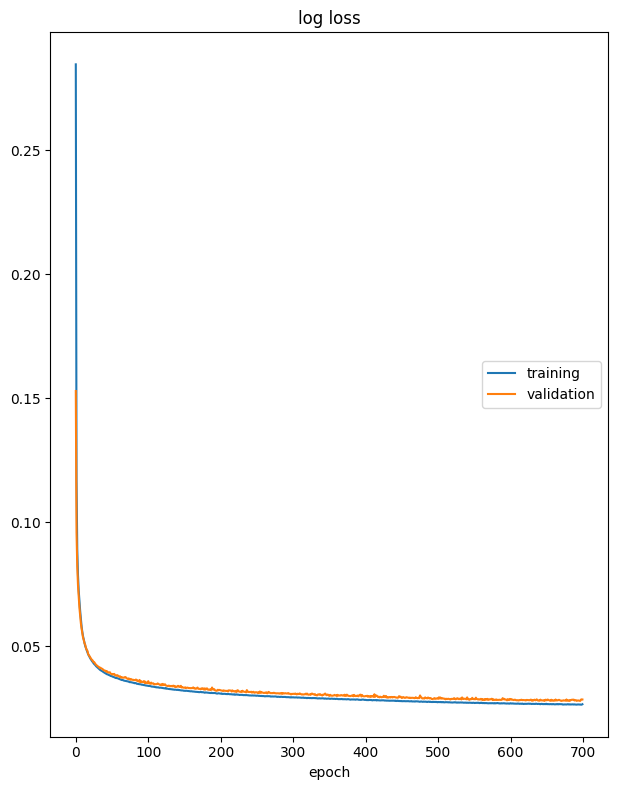

log loss
	training         	 (min:    0.027, max:    0.285, cur:    0.027)
	validation       	 (min:    0.028, max:    0.153, cur:    0.029)
0.028632428497076035


In [ ]:
#train model
n_epochs = 700

liveloss = PlotLosses()    # plots evolution of loss and accuracy
for epoch in range(n_epochs):
    logs = {}
    train_loss= torch.sqrt(mlptrain(model, optimizer, criterion, train_loader,device = device))

    logs['' + 'log loss'] = train_loss.item()
    # logs['' + 'accuracy'] = train_accuracy.item()

    validation_loss= torch.sqrt(mlpvalidate(model, criterion, validation_loader,device=device))
    logs['val_' + 'log loss'] = validation_loss.item()
    # logs['val_' + 'accuracy'] = validation_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()
    print(validation_loss.item())

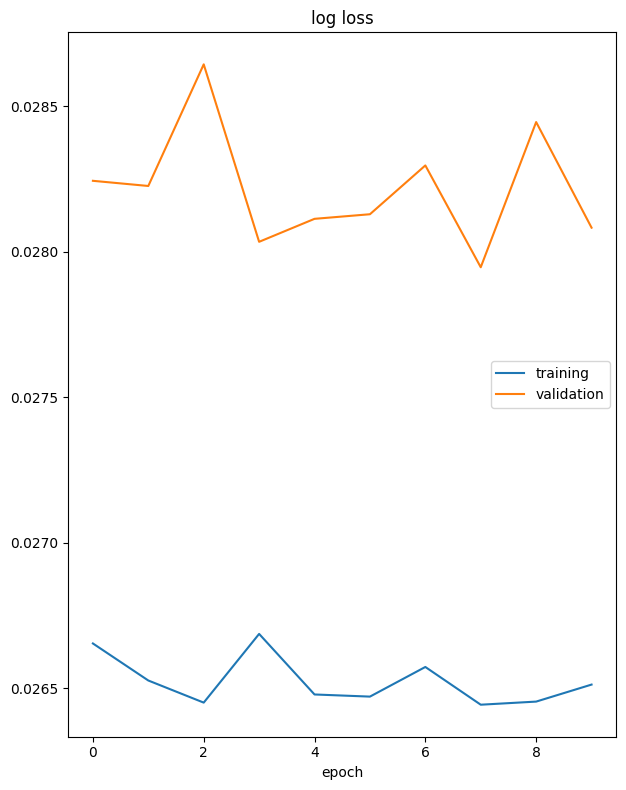

log loss
	training         	 (min:    0.026, max:    0.027, cur:    0.027)
	validation       	 (min:    0.028, max:    0.029, cur:    0.028)
0.02808254025876522


In [ ]:
# lr = 1e-4 another 10 epoch, the loss barely changing even zooming in

liveloss = PlotLosses()    # plots evolution of loss and accuracy
for epoch in range(10):
    logs = {}
    train_loss= torch.sqrt(train(model, optimizer, criterion, train_loader))

    logs['' + 'log loss'] = train_loss.item()
    # logs['' + 'accuracy'] = train_accuracy.item()

    validation_loss= torch.sqrt(validate(model, criterion, validation_loader))
    logs['val_' + 'log loss'] = validation_loss.item()
    # logs['val_' + 'accuracy'] = validation_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()
    print(validation_loss.item())

In [ ]:
#The part below is to predict on validation set. Plus a visulazation of model.
a,b = next(iter(validation_loader ))
a, b = a.to(device), b.to(device)

In [ ]:
! pip install -q torchview
! pip install -q -U graphviz

In [ ]:
from torchview import draw_graph
import graphviz

# when running on VSCode run the below command
# svg format on vscode does not give desired result
graphviz.set_jupyter_format('png')

'svg'

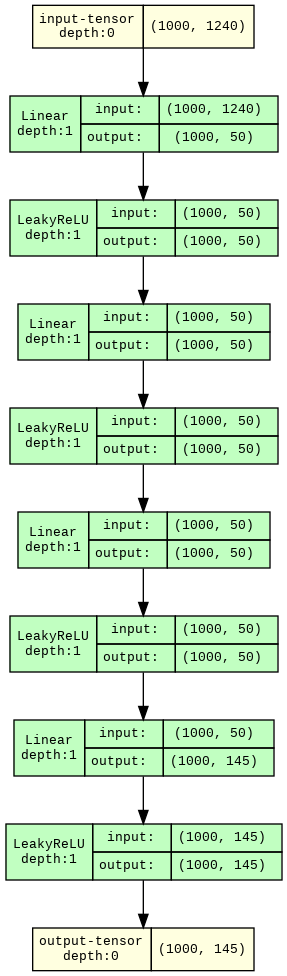

In [ ]:
model_graph = draw_graph(model, input_data=a,    graph_name='MLP',)

model_graph.visual_graph

In [ ]:
res = model(a)

In [ ]:
res.shape

torch.Size([1000, 145])

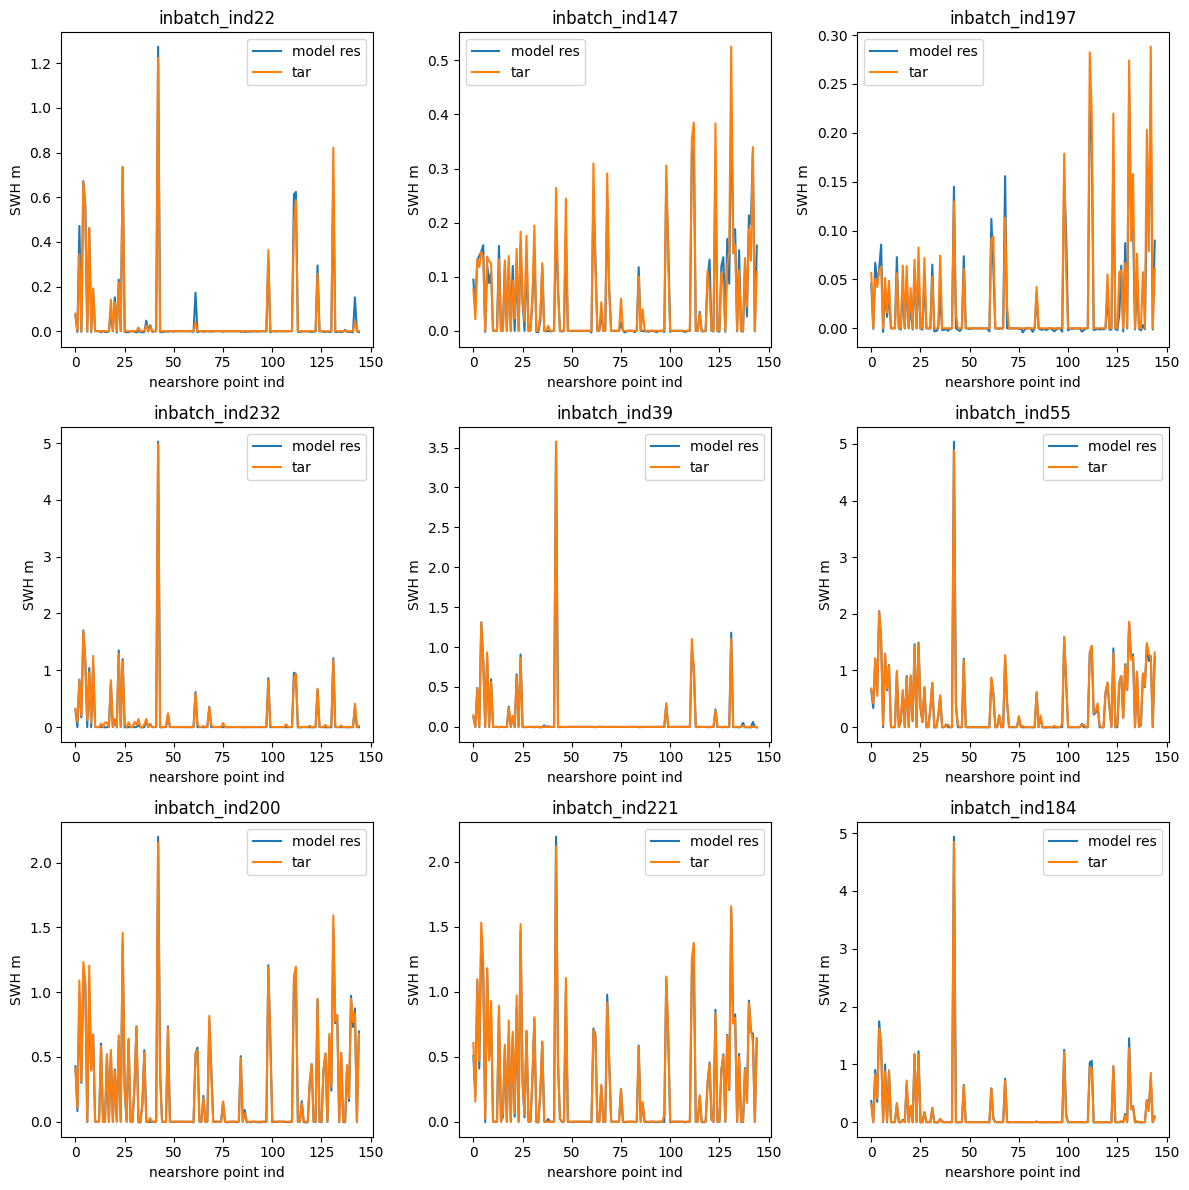

In [ ]:
fig = plt.figure(figsize=(12, 12))
fignum = 9
for ind,i in enumerate(generate_random_numbers(fignum, 0, 255)):
    plt.subplot(3, 3, ind+1)
    plt.plot(res[i].cpu().detach().numpy(), label=f'model res') # -1 here, use the last of the sequence as output
    plt.plot(b[i].cpu().detach().numpy(), label=f'tar')

    plt.xlabel('nearshore point ind')
    plt.ylabel('SWH m')
    plt.title(f'inbatch_ind{i}')
    plt.legend()

plt.tight_layout()
plt.show()

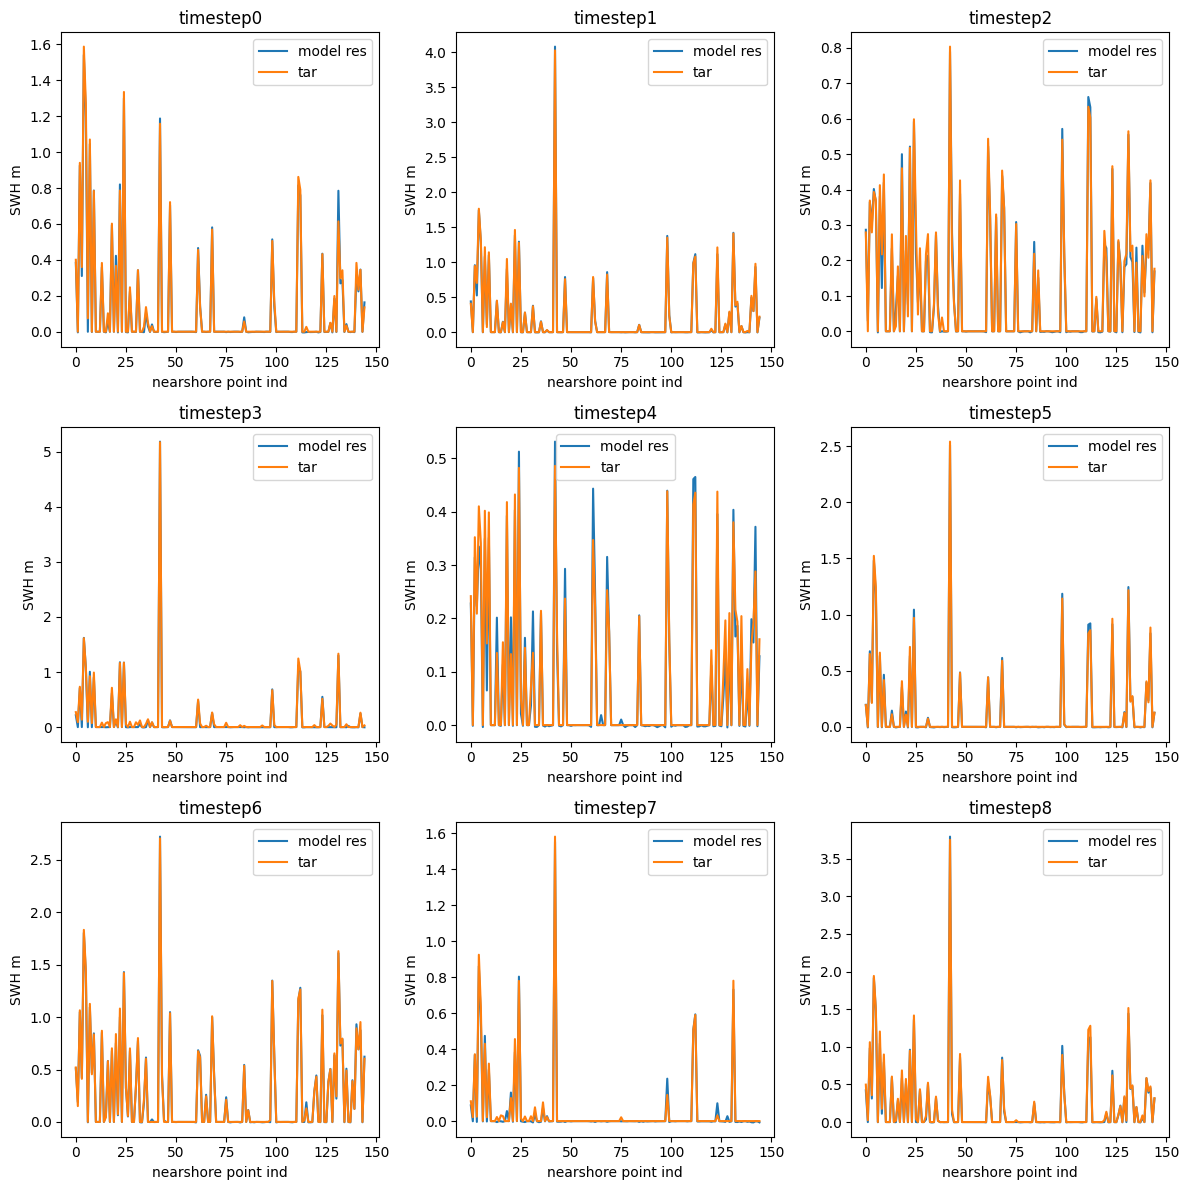

In [ ]:
# 9 more images
fig = plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.plot(res[i,:].cpu().detach().numpy(), label=f'model res')
    plt.plot(b[i,:].cpu().detach().numpy(), label=f'tar')

    plt.xlabel('nearshore point ind')
    plt.ylabel('SWH m')
    plt.title(f'timestep{i}')
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# torch.save(model, '/content/drive/MyDrive/IRP/model/MLP25m3.npy')